# Pranjal's Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal as signal
import mat73
from proSVD import proSVD

In [2]:
data_dict = mat73.loadmat('indy_20160407_02.mat')

units_unsorted = []
units_sorted = []

for ch_curr in data_dict['spikes']:
    units_unsorted.append(ch_curr[0]) # from data description, first unit is unsorted
    for unit_curr in ch_curr[1:]:
        if unit_curr is not None:
            units_sorted.append(unit_curr)

In [3]:
%matplotlib qt
ax = plt.figure().add_subplot(projection='3d')
s = slice(0,500)
ax.plot(data_dict['finger_pos'][s,0],data_dict['finger_pos'][s,1], data_dict['finger_pos'][s,2])


In [4]:
bin_size_ms = 10
timesteps = int(1000 / bin_size_ms) # todo: what is this for?

mintime, maxtime = 100, 0
for spk_times_curr in units_sorted:
    mintime = min(spk_times_curr[0], mintime)
    maxtime = max(spk_times_curr[-1], maxtime)

mintime = max(mintime,data_dict["t"][0])
maxtime = min(maxtime,882)

In [5]:
spk_bins = np.arange(mintime, maxtime, bin_size_ms/1000)
spks_binned = []

for i, unit_curr in enumerate(units_sorted):
    spks_binned_curr, _ = np.histogram(unit_curr, bins=spk_bins, range=(spk_bins[0], spk_bins[-1]))
    spks_binned.append(spks_binned_curr)

data = np.array(spks_binned).T

In [6]:
spk_bins

array([ 65.  ,  65.01,  65.02, ..., 881.97, 881.98, 881.99])

In [7]:
l1 = 100 # columns used to initialize
l = 1 # columns per update
k=6 # reduced dimension

num_iters = np.floor((data.shape[0] - l1 - l)/l).astype('int')
update_times = np.arange(l1, num_iters*l, l) # index of when updates happen (not including init)

In [8]:
kern_sd = 50
smooth_filt = signal.gaussian(int(6 * kern_sd / bin_size_ms), int(kern_sd / bin_size_ms), sym=True)
smooth_filt /=  np.sum(smooth_filt)
data_init_smooth = np.apply_along_axis(lambda x, filt: np.convolve(x, filt, 'same'), 
                                       0, data[:l1, :], filt=smooth_filt)

In [9]:
smooth_filt.shape

(30,)

In [10]:
pro = proSVD(
    k=k,
    decay_alpha=1, 
    trueSVD=True, 
    history=0
)

pro.initialize(data_init_smooth.T)

In [11]:
data_red = np.zeros((data.shape[0], k))
data_red[:l1, :] = data_init_smooth @ pro.Q



pro_end = int(data.shape[0]/8) # when proSVD will stop updating and bubblewrap starts

pro_diffs = []
smooth_window = data[l1-len(smooth_filt):l1, :]

for i, t in enumerate(update_times):
    start, end = t, t+pro.w_len
    dat_curr = data[start:end, :]
    smooth_window[:-1, :] = smooth_window[1:, :]
    smooth_window[-1, :] = dat_curr
    dat_smooth = smooth_filt @ smooth_window

    # # proSVD updates
    # if t < pro_end:  # only update for first n steps
    pro.preupdate()
    pro.updateSVD(dat_smooth[:, None])
    pro.postupdate()
    pro_diffs.append(np.linalg.norm(pro.Q-pro.Q_prev, axis=0))

    # getting projected data

    data_red[start:end, :] = dat_smooth @ pro.Q


In [16]:
obs = []
for i in range(len(spk_bins)-1):
    s = ((spk_bins[i] < data_dict['t']) & (data_dict['t'] < spk_bins[i+1]))
    if s.sum() == 0:
        obs.append(obs[-1])
    else:
        obs.append(data_dict['finger_pos'][s,:].mean(axis=0))
obs = np.array(obs)

In [19]:
obs.shape

(81699, 3)

In [ ]:
d = data - data.mean(axis=0)
d = data / data.std(axis=0)
d = np.hstack([d, np.ones([data_red.shape[0],0])])
w = np.linalg.inv(d.T@d)@d.T@obs[:,None]


In [21]:
# x: (1, n, d)
# y: (n,)
np.savez("monkey_reach_reduced_pro_all_bw_all_finger_all.npz", x=obs[pro_end:], y=data_red[None,pro_end:,:])

In [ ]:
obs.shape

In [ ]:
%matplotlib qt
x = spk_bins[:-1]
plt.plot(x,obs)
plt.plot(x,d@w)

In [ ]:
plt.plot(w)

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
%matplotlib inline

In [16]:
y = np.squeeze(np.load("jpca_reduced.npy"))

In [17]:
with np.load("clock_wandering_01.npz") as data:
    # x = np.squeeze(data['x'])
    # y = np.squeeze(data['y'])
    print(data['y'].shape)

(1, 10000, 2)


In [18]:
with np.load("clock_wandering_01.npz") as data:
    # x = np.squeeze(data['x'])
    # y = np.squeeze(data['y'])
    print(data['x'].shape)

(10000,)


In [19]:
y.shape

(6, 2268)

In [20]:
# x: (1, n, d)
# y: (n,)
# np.savez("jpca_reduced_sc.npz", x=obs, y=y.T[None,:,:])

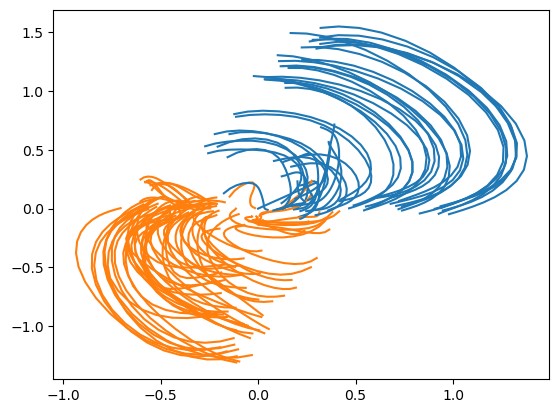

In [21]:
%matplotlib inline
fig, ax = plt.subplots()
t = 21

cps = np.array([[0.223, -0.301],[0,0]])
cps = np.fliplr(cps)
cps[:,0] *= -1

for i in range(y.shape[1]//t):
    
    # ax.plot(y[0,(i+1)*t-1], y[1,(i+1)*t-1], 'r.')
    if cps[0,:] @ y[:2,i*t] >0:
        c = 'C0'
    else:
        c = 'C1'
    ax.plot(y[0,i*t:t*(i+1)], y[1,i*t:(i+1)*t], color=c)
ax.plot(cps[:,0], cps[:,1])



In [22]:
obs = np.zeros(y.shape[1])
trail_length = 21
for i in range(obs.shape[0]//trail_length):
    b = -1 if np.array([0.301,  0.223]) @ y[:2,i*trail_length] > 0 else 1
    obs[i*trail_length:(i+1)*trail_length] = np.arange(trail_length) * b


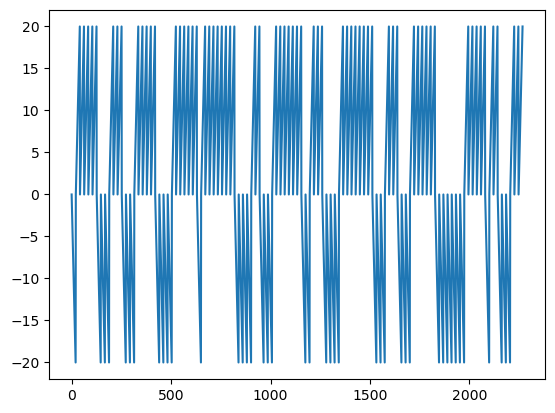

In [23]:
plt.plot(obs)